Поскольку у pymc3 какие-то проблемы с theano, на Colab пришлось поставить dev версию через github.

In [2]:
!pip install git+https://github.com/pymc-devs/pymc3 numpyro numpy pandas matplotlib seaborn arviz scipy

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-1wza3mjm
  Running command git clone -q https://github.com/pymc-devs/pymc3 /tmp/pip-req-build-1wza3mjm
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 256kB 9.1MB/s 
     |████████████████████████████████| 1.5MB 37.3MB/s 
  Created wheel for pymc3: filename=pymc3-4.0-cp37-none-any.whl size=879796 sha256=91d9f5b08cc548fd03150f251eef86bf3090af00d11bcf05d8daf50f6e02f17a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bc5qw0jh/wheels/a1/e3/71/a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
Successfully built pymc3
  Created wheel for aesara: filename=aesara-2.1.0-cp37-none-any.whl size=1563840 sha256=e8d52a4906f521f3c883e472bdaa201c8dc570b5a6b796c360e0263ad8f27f37
  Stored in directory: /root/.cache/pip/wheels/b2/0c/97/9f91fcf2e5d32430f4b7a5ae

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
sns.set()
from scipy import stats

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [5]:
import jax.numpy as jnp
import jax
from jax import random, vmap
from jax.scipy.special import logsumexp

In [6]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

Вспомним формулу Байеса:
$$
p(\theta | x) = \dfrac{p(x | \theta)p(\theta)}{p(x)}
$$

Простой дискретный пример.

В Небольшом пруду водятся караси и щуки, причём согласно поверью, в любой момент времени доля карасей в Небольшом пруду может равновероятно быть либо $1/3$, либо $2/3$ в зависимости от погодных условий. Исследовательница Авдотья вылавливает десять рыб подряд. Оказалось, что в полученной выборке шесть щук и четыре карася.

а) Найдите оценку максимального правдоподобия $\hat{p}_{c}$, рассуждая с позиций частотного подхода.

Ответ: $\hat{p}_{c} = 4/10$

б) Сделаем то же самое в рамках байесовского подхода. 

$$ 
p(\theta | y)  \propto p(y| \theta) \times p(\theta)
$$

$ p(\theta) = 1/2 $ (оба значения доли карасей равновероятны), $ p(y| \theta) = p^x \times (1-p)^{n-x}$. Посчитаем апостериорное распределение для обоих возможных значений $p$: 

In [7]:
p1 = (1/3) ** 4 * (2/3) ** 6 * (1/2)
p2 = (2/3) ** 4 * (1/3) ** 6 * (1/2)
print(f"Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет {p1/(p1+p2)}.")
print(f"Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет {p2/(p1+p2)}.")

Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет 0.8.
Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет 0.2.


Это вполне логично - 0.4 ближе к 1/3, чем к 2/3. 

#### Задание 1. Караси и щуки.

В Большом пруду водятся караси и щуки, причём согласно поверью, вероятность встретить карася равномерно распределена на отрезке от 0 до 1. Ловля рыбы в Большом пруду запрещена, поэтому исследовательница Авдотья решает провести численный эксперимент для вывода апостериорного распределения вероятности встретить карася.

Сгенерируйте выборку из из 100 наблюдений, каждое из которых является идентификатором того, является ли пойманная рыба карасём.

In [8]:
y = stats.bernoulli(p=0.3).rvs(100)
print('Доля карасей в выборке:', y.mean())
y

Доля карасей в выборке: 0.29


array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0])

1. Задайте вероятностную модель.

In [9]:
def model(y):
  p = numpyro.sample('share', dist.Uniform(0, 1))
  y_obs = numpyro.sample('obs', dist.Bernoulli(p), obs=y)

2. Оцените модель и получите приблизительное апостериорное распределение параметров.

In [10]:
kernel = NUTS(model) # NUTS sampler 
# 100 первых наблюдений будет выкинуто при оценке апостериорного распределения
# оставшиеся 500 наблюдений будут сохранены
mcmc = numpyro.infer.MCMC(kernel, num_warmup=100, num_samples=1000)
mcmc.run(random.PRNGKey(123), y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:02<00:00, 431.77it/s, 3 steps of size 7.61e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     share      0.30      0.05      0.30      0.22      0.37    270.54      1.01

Number of divergences: 0


In [11]:
print(f"Выборочное среднее апостериорного распределения: {samples_1['share'].mean()}.")

Выборочное среднее апостериорного распределения: 0.2962043285369873.


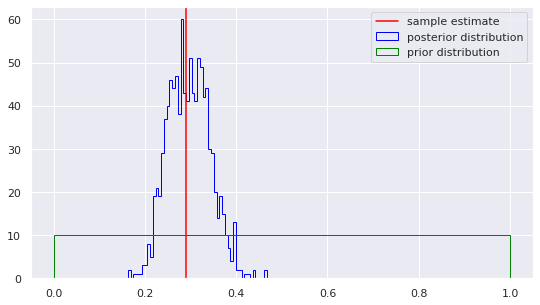

In [12]:
plt.figure(figsize=(9, 5));
plt.hist(samples_1['share'], bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');


У `numpyro` заметно сразу два минуса:
* Нельзя нарисовать динамику по цепям для генерируемого апостериорного распределения.
* Не считаются никакие статистики, которые говорили бы о сходимости апостериорного распределения. В этом плане `PyMC3` гораздо лучше.

Попробуем то же самое сделать через PyMC3, благо синтаксис похож.

In [13]:
ndraws = 1000
nburn = 100

with pm.Model() as model:
  p = pm.Uniform('p', lower=0, upper=1)
  y_obs = pm.Bernoulli('obs', p=p, observed=y)

  step = pm.NUTS()
  trace = pm.sample(# сколько наблюдений мы хотим сэмплировать
                    ndraws,
                    # сколько наблюдений мы хотим "сжечь"
                    tune=nburn, 
                    # удаляем ли мы "сжигаемые" набл-я из апостериорной выборки
                    discard_tuned_samples=True, 
                    # сэмплировщик
                    step=step, 
                    random_seed=np.random.seed(123),
                    # количество ядер, чтоб считать параллельно
                    cores=4,
                    # количество цепей Маркова
                    chains=4)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.9368125283078671, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9255368993368674, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9149732461652827, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9040677681154989, but should be close to 0.8. Try to increase the number of tuning steps.


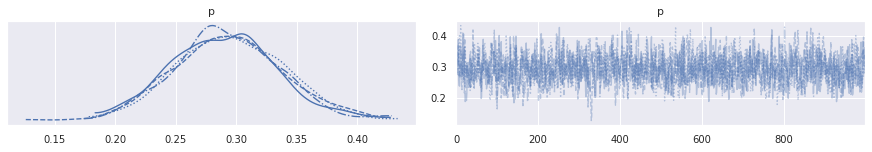

In [14]:
az.plot_trace(trace);

В `trace` есть много чего, при желании можно вытащить, например, выборку из апостериорного распределения для каждой цепи. 

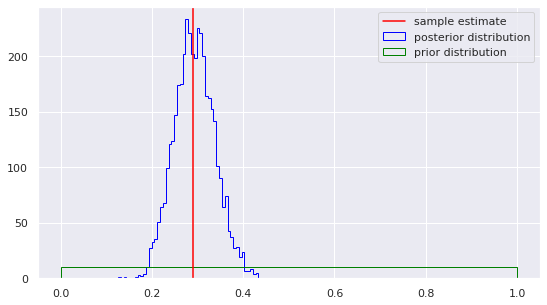

In [15]:
plt.figure(figsize=(9, 5));
plt.hist(np.array(trace.posterior.p).ravel(), bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');

Попробуем вытащить характеристики апостериорного распределения:

In [16]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.293,0.044,0.209,0.375,0.001,0.001,1589.0,1778.0,1.0


In [17]:
print(f"Выборочное среднее апостериорного распределения: {np.array(trace.posterior.p).ravel().mean()}.")

Выборочное среднее апостериорного распределения: 0.292954050207921.


Посмотрим, удалились ли те наблюдения из апостериорного распределения, которые мы хотели сжечь. Если да, то shape у trace.posterior.p = (4, 1000).

In [18]:
np.array(trace.posterior.p).shape

(4, 1000)

#### Задание 2. Структурный сдвиг.

In [19]:
years = np.arange(1800, 2000)
casual_1 = stats.poisson(3).rvs(100)
casual_2 = stats.poisson(1).rvs(100)
casualties = np.hstack((casual_1, casual_2))

In [20]:
df = pd.DataFrame({'year': years, 'casualties': casualties})

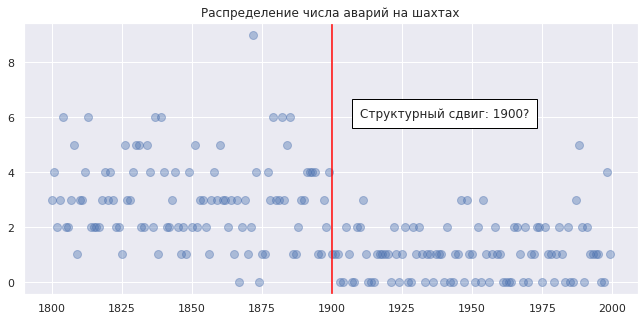

In [21]:
plt.figure(figsize=(11, 5));
plt.plot(df.year, df.casualties, 'o', alpha=0.4, markersize=8);
plt.title('Распределение числа аварий на шахтах');
plt.axvline(1900, color='red');
plt.text(1910, 6, 'Структурный сдвиг: 1900?', bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

Будем считать, что авариина шахте распределены по Пуассону и независимы:
$x_i \sim \mathrm{Pois}(\lambda)$, где

$$
\lambda = \begin{cases}
\lambda_1, t < \tau, \\
\lambda_2, t \ge \tau
\end{cases}
$$

Априорное распределение $\lambda$: $\lambda \sim \mathrm{Exp}(\alpha)$, где $alpha$ - некоторый гиперпараметр, который мы не знаем.

Оценим $\alpha$ на основе выборки:

In [22]:
y = casualties
alpha = 1 / np.mean(y)
alpha

0.4938271604938272

In [23]:
with pm.Model() as DisasterModel:
  # априорные распределения параметров
  tau = pm.DiscreteUniform("tau", lower=years.min(), upper=years.max())

  early_rate = pm.Exponential("early_rate", alpha)
  late_rate = pm.Exponential("late_rate", alpha)

  # разные значения alpha в зависимости от tau
  rate = pm.math.switch(tau>=years, early_rate, late_rate)

  # связь y c rate
  y_obs = pm.Poisson('disasters', rate, observed=y)

In [25]:
n_draws = 1000
n_burn = 100

with DisasterModel:
  sample = pm.sample(draws=n_draws,
                     tune=n_burn,
                     chains=4, 
                     cores=4, 
                     random_seed=np.random.seed(123))

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [tau]
INFO:pymc3:>Metropolis: [tau]
>NUTS: [early_rate, late_rate]
INFO:pymc3:>NUTS: [early_rate, late_rate]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 7 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9378240196729055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9475293718400596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9446227573988571, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9423114238298026, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This

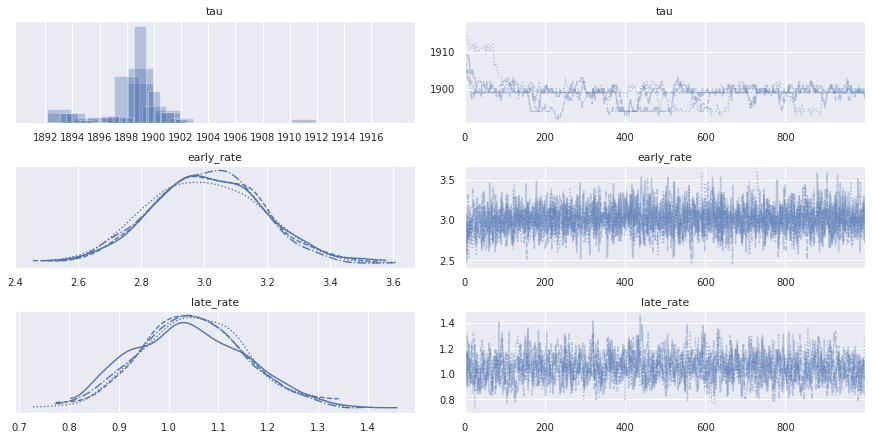

In [27]:
az.plot_trace(sample);

In [28]:
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1898.914,2.880,1894.000,1902.000,0.557,0.399,46.0,41.0,1.08
early_rate,3.007,0.176,2.673,3.330,0.004,0.003,1553.0,2323.0,1.00
late_rate,1.050,0.108,0.842,1.244,0.003,0.002,1087.0,1575.0,1.00


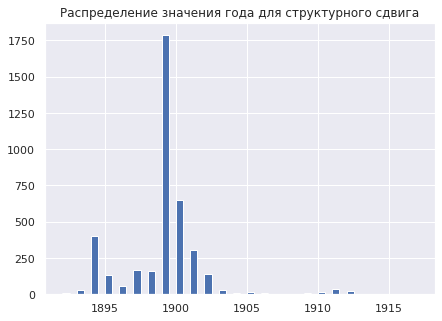

In [38]:
plt.figure(figsize=(7, 5));
plt.hist(np.array(sample.posterior.tau).ravel(), bins=50);
plt.title('Распределение значения года для структурного сдвига');


Оценим вероятность того, что $\lambda_i$ различны:

In [40]:
np.mean(np.array(sample.posterior.early_rate) - \
        np.array(sample.posterior.late_rate) > 0)

1.0